# <center> CS559 Homework#3: heart attack prediction classifiers</center>
## <center> Due: 8/6/2021 Friday at 11:59 PM</center>

In this assignment, you are going to implement four classifiers - **decision tree, random forest, adaboost, and gradient boost** - to predict the risk of heart attack. 
For each implementation, 
- no limits on pre-processing and EDA. 
- do not use any outside references - only the lecture note is allowed. 
- must test the accuracy of your algorithm and compare with the built-in classifiers. 
- must evaluate your implementations. 

Here are data attributes:
- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- ca: number of major vessels (0-3)
- cp : Chest Pain type chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach : maximum heart rate achieved
- output : 0= less chance of heart attack 1= more chance of heart attack

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
from math import log
from math import e
import warnings
warnings.filterwarnings("ignore")

In [2]:
heart = pd.read_csv('heart.csv')

In [3]:
heart

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


### Question 0: EDA and Pre-processing (10 pts)
The EDA and Pre-processing are not limitted however, you must
1. check if the data is **balanced** or not. 
2. check if features are **skewed** or not.
3. check outliers. 

For any finds from 1 to 3, please handle the data carefully. Exaplin your workflow and perform accordingly. If any interesting facts are learned, please state them. 

<AxesSubplot:>

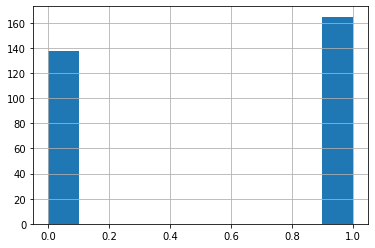

In [4]:
heart['output'].hist()

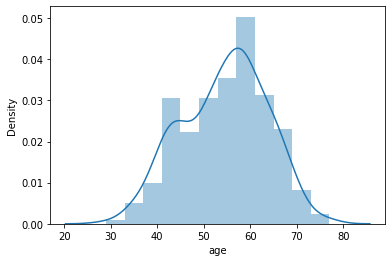

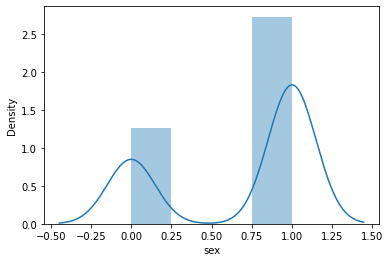

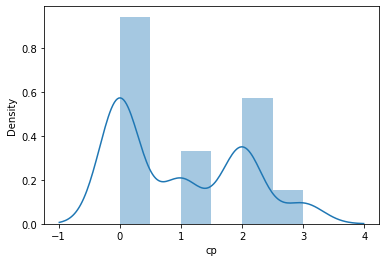

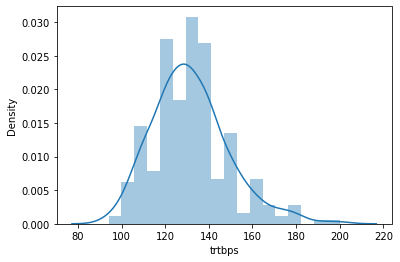

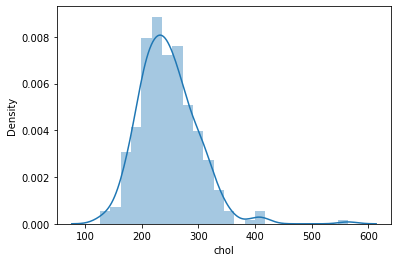

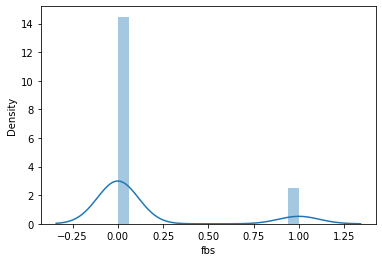

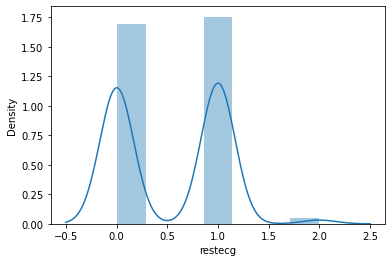

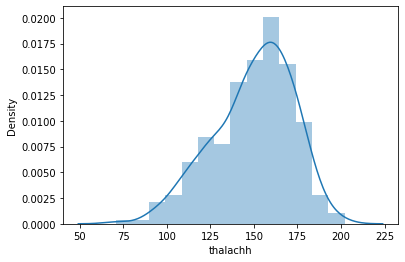

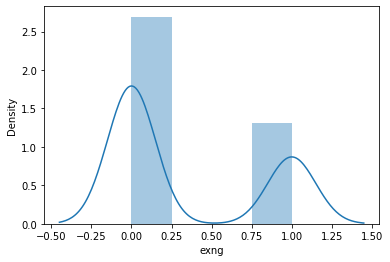

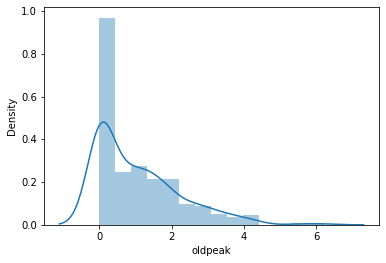

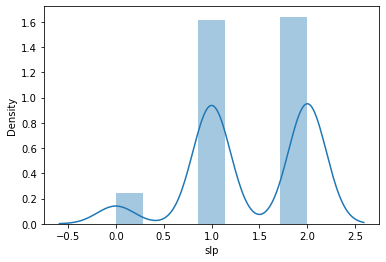

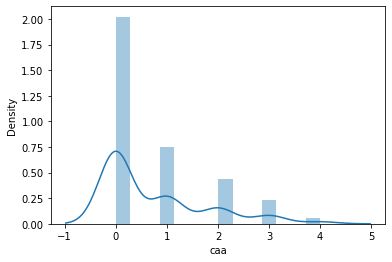

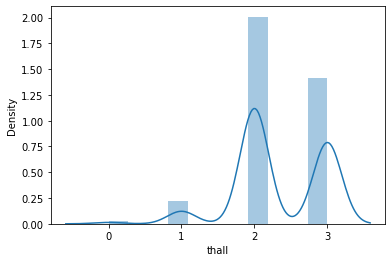

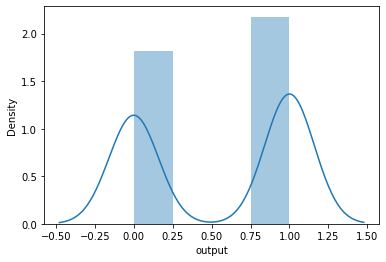

In [5]:
for i, col in enumerate(heart.columns):
    plt.figure(i)
    sns.distplot(heart[col])

In [6]:
heart.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Our dataset is very balanced as our output variable has ~140 occurences for low risk and ~165 occurences for high risk. Since the output occurences are almost even, any classifier we make should be equally good at predicting both high risk and low risk cases by training with this data.

As for skew, generally speaking there is some skew among the features. thall, sip, thalachh, and sex all have varying degress of left skew while caa, oldpeak, exng, restecg, fbs, chol, trtbps, and cp all have varying degrees of right skew. The only 2 relatively symmetric features are age and output.

In [7]:
outliers = {}
for i, col in enumerate(heart.columns):
    temp = []
    for j in range(len(heart[col])):
        if (heart[col][j] > (heart[col].mean() + 3 * heart[col].std())):
            temp.append(heart[col][j])
    outliers[col] = temp
print(outliers)

{'age': [], 'sex': [], 'cp': [], 'trtbps': [200, 192], 'chol': [417, 564, 407, 409], 'fbs': [], 'restecg': [], 'thalachh': [], 'exng': [], 'oldpeak': [6.2, 5.6], 'slp': [], 'caa': [4, 4, 4, 4, 4], 'thall': [], 'output': []}


### Question 1: Decisition Tree Classifier
- DT implementation (10 pts)
- Classification using DecistionTreeClassifier (5 pts)
- Evaluation (5 pts)

In [8]:
class Node:
    def __init__(self, data, parent):
        self.children = []
        self.parent = parent
        self.data = data
        self.name = len(data)
    def AddChild(self, child):
        self.children.append(child)
    def AddChildren(self, children):
        self.children.extend(children)
    def setData(self, data):
        self.data = data
        self.name = len(data)
    def display(self,indent=0):
        print( ('  '*indent), self.name)        
        for c in self.children:
            c.display(indent+1)

In [9]:
# need to loop through all questions possible and calculate gini index and information gained to find right question

#df: dataframe
#col: string, name of column we're splitting on
#every_val: bool, true if data is categorical (i.e. making a split for every unique value); false if data is continuous
#threshold: int/float, only used when every_val is false, ignored otherwise; sets threshold to compare continuous values
def DecisionTreeSplit(full_df, df, indices, col, every_val, threshold):
    if every_val:
        uniques = full_df[col].unique()
        bins = len(uniques)
    else:
        #for continuous data, we're simply checking if the values are >= the given threshold and splitting into 2 branches
        bins = 2
    
    children = []
    for i in range(bins):
        children.append([])
    
    for i in indices:
        if every_val:
            for j in range(len(uniques)):
                if df[col][i] == uniques[j]:
                    children[j].append(i)
        else:
            if df[col][i] >= threshold:
                children[0].append(i)
            else:
                children[1].append(i)
    
    return children

In [10]:
#nodes is a 2d list of node objects. For my use it'll be the 'children' list returned from DecisionTreeSplit()
#find weighted average impurity for all branches, subtract from starting uncertainty for info gain
def gini_impurity(nodes, target):
    impurities = []
    for branch in nodes:
        impurity = 1
        high_risk = 0
        low_risk = 0
        for i in branch:
            if target[i] == 0:
                low_risk += 1
            else:
                high_risk += 1
        if(float(len(branch)) == 0):
            prob_low = 0
            prob_high = 0
        else: 
            prob_low = low_risk / float(len(branch))
            prob_high = high_risk / float(len(branch))
        impurity -= (prob_low**2 + prob_high**2)
        impurities.append(impurity)
    return impurities

In [11]:
cols = [['age', False], ['sex', True], ['cp', True], ['trtbps', False], ['chol', False], 
        ['fbs', True], ['restecg', True], ['thalachh', False], ['exng', True], ['oldpeak', False], 
        ['slp', True], ['caa', True], ['thall', True]]

In [120]:
def FindBestSplit(full_df, df, cols, indices, start_impurity, target, question_root, ada):
    info_gain = 0
    best_gini = []
    best_split = []
    for col in cols:
        if col[0] in df.columns:
            # if data is categorical, we make a branch for every unique value
            if col[1]:
                split = DecisionTreeSplit(full_df, df, indices, col[0], True, 0)
                gini = gini_impurity(split, target)
            
                total = 0
                for branch in split:
                    total += len(branch)

                weighted_imp = 0
                for j in range(len(gini)):   
                    weighted_imp += gini[j] * (len(split[j])/total)
            
                if(start_impurity - weighted_imp > info_gain):
                    info_gain = start_impurity - weighted_imp
                    best_gini = gini
                    best_split = split
                    if info_gain > 0.09:
                        question_root.setData([col[0], -1])
                    elif ada:
                        question_root.setData([col[0], -1])
            # if data is continuous, we make 2 branches with left branch being >= to a value and right branch being < value
            # inner loop checks every value in table for best split
            # somewhat costly, but can't think of a better or simpler way to do it
            else:
                for i in indices:
                    split = DecisionTreeSplit(full_df, df, indices, col[0], False, df[col[0]][i])
                    gini = gini_impurity(split, target)
                
                    total = 0
                    for branch in split:
                        total += len(branch)

                    weighted_imp = 0
                    for j in range(len(gini)):   
                        weighted_imp += gini[j] * (len(split[j])/total)
                
                    if(start_impurity - weighted_imp > info_gain):
                        info_gain = start_impurity - weighted_imp
                        best_gini = gini
                        best_split = split
                        if info_gain > 0.09:
                            question_root.setData([col[0], df[col[0]][i]])
                        elif ada:
                            question_root.setData([col[0], df[col[0]][i]])
    return info_gain, best_gini, best_split

In [113]:
def BuildTree(full_df, df, target, root, start_impurity, question_root):
    info_gain, gini, split = FindBestSplit(full_df, df, cols, root.data, start_impurity, target, question_root, False)
    # threshold for info gain, subject to change
    if info_gain > 0.09:
        for child in split:
            if child != []:
                new_child = Node(child, root)
                new_child_question = Node([], question_root)
                root.AddChild(new_child)
                question_root.AddChild(new_child_question)
        for i in range(len(root.children)):
            BuildTree(full_df, df, target, root.children[i], gini[i], question_root.children[i])

In [14]:
data_vars = heart.drop(heart.columns[[13]], axis=1)
target = heart['output']
X_train, X_test, y_train, y_test = train_test_split(data_vars, target, train_size=0.8, stratify=target)

high_risk = 0
low_risk = 0
start_impurity = 1
for val in y_train:
    if val == 0:
        low_risk += 1
    else:
        high_risk += 1
prob_low = low_risk / float(len(y_train))
prob_high = high_risk / float(len(y_train))
start_impurity -= (prob_low**2 + prob_high**2)
print(start_impurity)

root = Node(X_train['age'].index, None)
question_root = Node([], None)
BuildTree(heart, X_train, y_train, root, start_impurity, question_root)

0.49586776859504145


In [15]:
def BuildTestTree(full_df, train_root, question_root, test_df, test_root):
    if len(question_root.data) > 0:
        if question_root.data[1] == -1:
            split = DecisionTreeSplit(full_df, test_df, test_root.data, question_root.data[0], True, 0)
            for child in split:
                if child != []:
                    new_child = Node(child, test_root)
                    test_root.AddChild(new_child)
            for i in range(len(test_root.children)):
                if i < len(train_root.children):
                    BuildTestTree(full_df, train_root.children[i], question_root.children[i], test_df, test_root.children[i])
        else:
            split = DecisionTreeSplit(full_df, test_df, test_root.data, question_root.data[0], False, question_root.data[1])
            for child in split:
                if child != []:
                    new_child = Node(child, test_root)
                    test_root.AddChild(new_child)
            for i in range(len(test_root.children)):
                if i < len(train_root.children):
                    BuildTestTree(full_df, train_root.children[i], question_root.children[i], test_df, test_root.children[i])

In [16]:
def DTScore(train_root, test_root, train_y, test_y):
    # getting classification for leaf
    if len(test_root.children) == 0:
        temp = 0
        target = 0
        for i in train_root.data:
            temp += train_y[i]
        if temp / len(train_root.data) >= 0.5:
            target = 1
        correct = 0
        for i in test_root.data:
            if test_y[i] == target:
                correct += 1
        return correct
    else:
        return sum(DTScore(train_root.children[i], test_root.children[i], train_y, test_y) for i in range(len(test_root.children)))

In [17]:
test_root = Node(X_test['age'].index, None)
BuildTestTree(heart, root, question_root, X_test, test_root)

In [18]:
# root.display()
# print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# test_root.display()
correct = DTScore(root, test_root, y_train, y_test)
print((correct / len(y_test))*100)

78.68852459016394


In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.predict(X_test)
DTC_accuracy = dt.score(X_test, y_test)*100
print(DTC_accuracy)

78.68852459016394


The accuracy for my implementation tends to be about 70% on average and is usually a little but lower than the sklearn implementation. It's possible that my reduced accuracy comes from my info gain threshold as well as from overfitting. The exact cause is difficult to pinpoint. Depending on the training and testing split, some trees will have overfitting and others will only have a handful of nodes. It's possible that having a more sophisticated threshold such as having a minimum number of children in a leaf as well as an info gain threshold might help. More preprocessing might help as well.

### Question 2: Random Forest Classifier
- RF implementation (10 pts)
- Classification using RandomForestClassifier (5 pts)
- Evaluation (5 pts)

In [20]:
def BootstrapData(data):
    bootstrap = np.random.choice(data, len(data))
    return bootstrap

In [21]:
def BuildRandomForest(full_df, df, bootstrap, target):
    high_risk = 0
    low_risk = 0
    start_impurity = 1
    for val in bootstrap:
        if y_train[val] == 0:
            low_risk += 1
        else:
            high_risk += 1
    prob_low = low_risk / float(len(bootstrap))
    prob_high = high_risk / float(len(bootstrap))
    start_impurity -= (prob_low**2 + prob_high**2)
    
    forest = []
    for t in range(20):
        print("tree: ", t)
        rf_root = Node(bootstrap, None)
        rf_question_root = Node([], None)
        
        random_cols = df.sample(n=6, axis=1)
        BuildTree(full_df, random_cols, target, rf_root, start_impurity, rf_question_root)
        forest.append([rf_root, rf_question_root])
    
    return forest

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data_vars, target, train_size=0.8, stratify=target)
bootstrap = BootstrapData(X_train['age'].index)
forest = BuildRandomForest(heart, X_train, bootstrap, y_train)

tree:  0
tree:  1
tree:  2
tree:  3
tree:  4
tree:  5
tree:  6
tree:  7
tree:  8
tree:  9
tree:  10
tree:  11
tree:  12
tree:  13
tree:  14
tree:  15
tree:  16
tree:  17
tree:  18
tree:  19


Only using 20 trees instead of 100 because using more seems to crash python. Whatever the bug is, I can't find it.

In [37]:
def RFScore(full_df, rf_forest, df_test, train_y, test_y):
    avg = 0
    counter = 0
    for tree in rf_forest:
        rf_test_root = Node(X_test['age'].index, None)
        BuildTestTree(full_df, tree[0], tree[1], df_test, rf_test_root)
        avg += DTScore(tree[0], rf_test_root, train_y, test_y) / len(test_y)
    return avg / (len(rf_forest))

In [40]:
print(RFScore(heart, forest, X_test, y_train, y_test)*100)

71.96721311475412


In [46]:
rf = RandomForestClassifier(max_features=6)
rf.fit(X_train, y_train)
rf.predict(X_test)
RFC_accuracy = rf.score(X_test, y_test)*100
print(RFC_accuracy)

78.68852459016394


My RandomForest implementation seems to be flawed in some way. It's likely that any issues in my decision tree implementation are compounding here. The accuracy is not too far off compared to the sklearn implementation, but there are some bugs that cause it not to run properly sometimes and I can only do a limited number of trees as opposed to the 100 I used with sklearn. 

### Question 3: AdaBoost Classifier
- AB implementation (15 pts)
- Classification using AdaBoostClassifier (5 pts)
- Evaluation (5 pts)

In [154]:
def BuildStump(full_df, df, target, root, start_impurity, question_root):
    info_gain, gini, split = FindBestSplit(full_df, df, cols, root.data, start_impurity, target, question_root, True)
    for i in range(len(split)):
        new_child = Node(split[i], root)
        new_child_question = Node([], question_root)
        if question_root.data[1] == -1:
            uniques = full_df[question_root.data[0]].unique()
            new_child_question.setData(['leaf', uniques[i]])
        else:
            new_child_question.setData(['leaf', question_root.data[1]])
        root.AddChild(new_child)
        question_root.AddChild(new_child_question)

In [150]:
def AdaBoostBuild(full_df, df, target):
    weights = [1/len(df['age'].index)] * len(full_df['age'].index)
    high_risk = 0
    low_risk = 0
    start_impurity = 1
    for val in target:
        if val == 0:
            low_risk += 1
        else:
            high_risk += 1
    prob_low = low_risk / float(len(target))
    prob_high = high_risk / float(len(target))
    start_impurity -= (prob_low**2 + prob_high**2)
    
    forest = []
    full_train = df['age'].index
    size = len(df['age'].index)
    for i in range(13):
        ab_train_root = Node(full_train, None)
        ab_question_root = Node([], None)
        BuildStump(full_df, df, target, ab_train_root, start_impurity, ab_question_root)
        error = 0
        wrong = 0
        for branch in ab_train_root.children:
            temp = 0
            for i in branch.data:
                temp += full_df['output'][i]
            if temp >= len(branch.data):
                wrong = 1
                temp = len(branch.data) - temp
            error += temp / size
        say = (1/2) * log(((1-error+0.0000001)/error), e)
        for branch in ab_train_root.children:
            for i in branch.data:
                if full_df['output'][i] == wrong:
                    weights[i] = weights[i] * e**(say)
                else:
                    weights[i] = weights[i] * e**(-1*say)
        forest.append([ab_train_root, ab_question_root, say])
        df = df.drop([ab_question_root.data[0]], axis=1)
    
    return forest

In [162]:
X_train, X_test, y_train, y_test = train_test_split(data_vars, target, train_size=0.8, stratify=target)
ada_forest = AdaBoostBuild(heart, X_train, y_train)

In [163]:
def AdaScoreHelp(full_df, train_root, question_root, df_test, train_y, test_y, i):
    right_leaf = -1
    if question_root.data[1] == -1:
        for j in range(len(question_root.children)):
            if question_root.children[j].data[1] == full_df[question_root.data[0]][i]:
                right_leaf = j
    else:
        if df_test[question_root.data[0]][i] >= question_root.data[1]:
            right_leaf = 0
        else:
            right_leaf = 1
    total = 0
    for val in train_root.children[right_leaf].data:
        total += train_y[val]
    if total / len(train_y) >= 0.5:
        return 1
    else:
        return 0

In [164]:
def AdaScore(full_df, ada_forest, df_test, train_y, test_y):
    correct = 0
    for i in df_test['age'].index:
        high_risk = 0
        low_risk = 0
        for tree in ada_forest:
            result = AdaScoreHelp(full_df, tree[0], tree[1], df_test, train_y, test_y, i)
            if result == 1:
                high_risk += tree[2]
            else:
                low_risk += tree[2]
        if low_risk >= high_risk:
            if test_y[i] == 0:
                correct += 1
        else:
            if test_y[i] == 1:
                correct += 1
    return correct / len(df_test['age'].index)

In [165]:
print(AdaScore(heart, ada_forest, X_test, y_train, y_test)*100)

54.09836065573771


In [172]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
ab.predict(X_test)
ABC_accuracy = ab.score(X_test, y_test)*100
print(ABC_accuracy)

80.32786885245902


My AdaBoost implementation does not give a good accuracy compared to the sklearn AdaBoost. In fact, my accuracy is only slightly higher than the expected accuracy from guessing. Since AdaBoost uses a compilation of weak classifiers to make a strong guess, my issue is likely that I have too few weak classifiers in my algorithm. I only included one stump tree for each feature. The reason for this is because I would have to drop the feature from the set of features to choose from after using it, or else the algorithm would make multiple identical trees from the same feature. If I could find a better way of making the stump trees so that I could make more of them, then I could probably improve my accuracy by a lot.

### Question 4: Gradient Boost Classifier
- GB implementation (15 pts)
- Classification using GradientBoostingClassifier (5 pts)
- Evaluation (5 pts)

In [102]:
temp = heart.drop(['age'], axis=1)

In [156]:
print(ada_forest[0][1].children[0].data)

ada_forest[0][1].display()
print(heart['caa'].unique())

['leaf', 1]
 2
   2
   2
   2
   2
[0 2 1 3 4]
